In [1]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

(examples:bryson_denham)=
# The Bryson-Denham Problem

The Bryson-Denham problem is a variation of the double integrator problem {cite}`bryson1975applied`. It can be stated as:

Minimize the control effort required to reverse the direction of motion of a frictionless sliding block such that the reversal happens with some limited amount of displacement.

## State and control variables

This system has two state variables, the position ($x$) and velocity ($v$) of the sliding block. 

This system has a single control variable ($u$), the acceleration of the block.

The dynamics of the system are governed by

\begin{align}
  \dot{x} &= v \\
  \dot{v} &= u
\end{align}



## Problem Definition

We seek to minimize the time required to exit the well in the positive direction.

\begin{align}
    \mathrm{Minimize} \, J &= 0.5 \int_0^1 u^2 dt
\end{align}

Subject to the initial conditions

\begin{align}
    x_0 &= 0.0 \\
    v_0 &= 1.0
\end{align}

and the terminal constraints

\begin{align}
    x_f &= 0.0 \\
    v_f &= -1.0
\end{align}

In addition, $x$ is constrained to remain below a displacement of 1/9.

\begin{align}
    x &\le 1/9
\end{align}

## Dealing with integral costs in Dymos

In classic optimal control, the objective is often broken into the terminal component (the Mayer term) and the integral component (the Lagrange term).
Dymos does not distinguish between the two.
In this case, since the objective $J$ is an integrated quantity, we add a term to the ODE

\begin{align}
\dot{J} &= 0.5 u^2
\end{align}

## Defining the ODE

The following code implements the equations of motion for the mountain car problem.
Since the rate of $x$ is given by another state ($v$), and the rate of $v$ is given by a control ($u$), there is no need to compute their rates in the ODE.
Dymos can pull their values from those other states and controls.
The ODE, therefore, only needs to compute the rate of change of $J$.

A few things to note:

1. By providing the tag `dymos.state_rate_source:{name}`, we're letting Dymos know what states need to be integrated, there's no need to specify a rate source when using this ODE in our Phase.
2. Pairing the above tag with `dymos.state_units:{units}` means we don't have to specify units when setting properties for the state in our run script.

In [2]:
import numpy as np
import openmdao.api as om


class BrysonDenhamODE(om.ExplicitComponent):
    
    def initialize(self):
        self.options.declare('num_nodes', types=int)
        
    def setup(self):
        nn = self.options['num_nodes']
        
        self.add_input('x', shape=(nn,), units='m')
        self.add_input('v', shape=(nn,), units='m/s')
        self.add_input('u', shape=(nn,), units='m/s**2')
        
        self.add_output('J_dot', shape=(nn,), units='m**2/s**4',
                        tags=['dymos.state_rate_source:J',
                              'dymos.state_units:m**2/s**3'])
        
        ar = np.arange(nn, dtype=int)
        
        self.declare_partials(of='J_dot', wrt='u', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        u = inputs['u']
        outputs['J_dot'] = 0.5 * u**2

    def compute_partials(self, inputs, partials):
        partials['J_dot', 'u'] = inputs['u']
        

## Solving the Bryson-Denham problem with Dymos

The following script solves the minimum-time mountain car problem with Dymos.
This problem is pretty trivial and can be solved using the SLSQP optimizer in scipy.

To begin, import the packages we require:

In [3]:
%matplotlib inline

In [4]:
import dymos as dm
import matplotlib.pyplot as plt

We then instantiate an OpenMDAO problem and set the optimizer and its options.

The call to `declare_coloring` tells the optimizer to attempt to find a sparsity pattern that minimizes the work required to compute the derivatives across the model.

SLSQP does not internally use this sparsity information to reduce memory and improve performance as some other optimizers do, but the performance due to the increased efficiency in computing derivatives still makes it worthwhile.

In [5]:
#
# Initialize the Problem and the optimization driver
#
p = om.Problem()
               
p.driver = om.ScipyOptimizeDriver()
p.driver.declare_coloring()

Next, we add a Dymos Trajectory group to the problem's model and add a phase to it.

In this case we're using the Radau pseudospectral transcription to solve the problem.

In [6]:
#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem('traj', dm.Trajectory())
tx = transcription=dm.Radau(num_segments=24)
phase = traj.add_phase('phase0', dm.Phase(ode_class=BrysonDenhamODE, transcription=tx))

At this point, we set the options on the main variables used in a Dymos phase.  

In addition to `time`, we have three states (`x`, `v`, and `J`) and a single control (`u`).  

Here we use bounds on the states themselves to constrain the initial and final value of `x` and `v`, and the initial value of `J`.
From an optimization perspective, this means that we are removing the first and last values in the state histories of $x$ and $v$ from the vector of design variables.
Their initial and final values will remain unchanged throughout the optimization process.

On the other hand, we could specify `fix_initial=False, fix_final=False` for these values, and Dymos would be free to change them.
We would then need to put a boundary constraint in place to enforce their final values.
Feel free to experiment with different ways of enforcing the boundary constraints on this problem and see how it affects performance.

The scaler values (`ref`) are all set to 1 here.

Bounds on time duration are guesses, and the bounds on the states and controls come from the implementation in the references.

Also, we don't need to specify targets for any of the variables here because their names _are_ the targets in the top-level of the model.
The rate source and units for the states are obtained from the tags in the ODE component we previously defined.

In [7]:
#
# Set the variables
#
phase.set_time_options(fix_initial=True, fix_duration=True)

phase.add_state('x', fix_initial=True, fix_final=True, rate_source='v')
phase.add_state('v', fix_initial=True, fix_final=True, rate_source='u')
phase.add_state('J', fix_initial=True, fix_final=False) # Rate source obtained from tags on the ODE outputs
phase.add_control('u', continuity=True, rate_continuity=False)

In [8]:
#
# Minimize time at the end of the phase
#
phase.add_objective('J', loc='final', ref=1)
phase.add_path_constraint('x', upper=1/9)

#
# Setup the Problem
#
p.setup()


--- Constraint Report [traj] ---
    --- phase0 ---
        [path]     x <= 1.1111e-01  [m]



We then set the initial guesses for the variables in the problem and solve it.

We're using the phase `interp` method to provide initial guesses for the states and controls.
In this case, by giving it two values, it is linearly interpolating from the first value to the second value, and then returning the interpolated value at the input nodes for the given variable.

Finally, we use the `dymos.run_problem` method to execute the problem.
This interface allows us to do some things that the standard OpenMDAO `problem.run_driver` interface does not.
It will automatically record the final solution achieved by the optimizer in case named `'final'` in a file called `dymos_solution.db`.
By specifying `simulate=True`, it will automatically follow the solution with an explicit integration using `scipy.solve_ivp`.
The results of the simulation are stored in a case named `final` in the file `dymos_simulation.db`.
This explicit simulation demonstrates how the system evolved with the given controls, and serves as a check that we're using a dense enough grid (enough segments and segments of sufficient order) to accurately represent the solution.

If those two solution didn't agree reasonably well, we could rerun the problem with a more dense grid.
Instead, we're asking Dymos to automatically change the grid if necessary by specifying `refine_method='ph'`.
This will attempt to repeatedly solve the problem and change the number of segments and segment orders until the solution is in reasonable agreement.

In [9]:
#
# Set the initial values
#

phase.set_time_val(initial=0.0, duration=1.0)

phase.set_state_val('x', [0, 0])
phase.set_state_val('v', [1, -1])
phase.set_state_val('J', [0, 1])
phase.set_control_val('u', [0, 0])

#
# Solve for the optimal trajectory
#
dm.run_problem(p, run_driver=True, simulate=True)


Model viewer data has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Full total jacobian for problem 'problem' was computed 3 times, taking 0.18549308413639665 seconds.
Total jacobian shape: (336, 286) 


Jacobian shape: (336, 286)  (1.30% nonzero)
FWD solves: 7   REV solves: 0
Total colors vs. total size: 7 vs 286  (97.55% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity:   0.1855 sec
Time to compute coloring:   0.0561 sec
Memory to compute coloring:   0.5625 MB
Coloring created on: 2024-08-14 10:31:10


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/total_jac.py:1646: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->x', inds=[(0, 0), (95, 0)])] cannot be impacted by the design variables of the problem.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.000014657972209
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization Complete
-----------------------------------
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings

Simulating trajectory traj
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/group.py:1104: DerivativesWarning:Constraints or objectives [ode_eval.control_interp.control_rates:u_rate2] cannot be impacted by the design variables of the problem because no partials were defined for them in their parent component(s).
/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_simulation.db, is being overwritten.


Done simulating trajectory traj


Problem: problem
Driver:  ScipyOptimizeDriver
  success     : True
  iterations  : 39
  runtime     : 4.0923E+00 s
  model_evals : 39
  model_time  : 1.4088E-02 s
  deriv_evals : 38
  deriv_time  : 1.0526E-01 s
  exit_status : SUCCESS

## Plotting the solution

The recommended practice is to obtain values from the recorded cases.
While the problem object can also be queried for values, building plotting scripts that use the case recorder files as the data source means that the problem doesn't need to be solved just to change a plot.
Here we load values of various variables from the solution and simulation for use in the animation to follow.

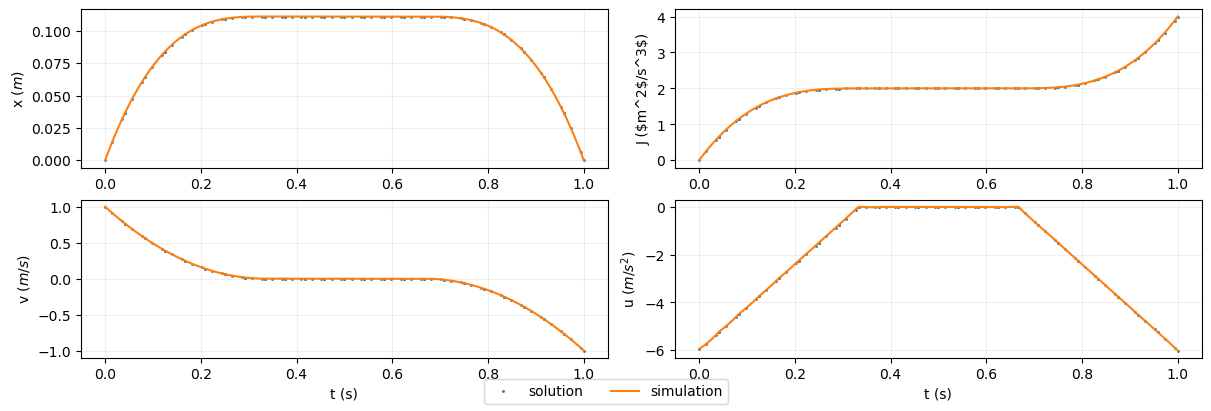

In [10]:
sol = om.CaseReader('dymos_solution.db').get_case('final')
sim = om.CaseReader('dymos_simulation.db').get_case('final')

t = sol.get_val('traj.phase0.timeseries.time')
x = sol.get_val('traj.phase0.timeseries.x')
v = sol.get_val('traj.phase0.timeseries.v')
J = sol.get_val('traj.phase0.timeseries.J')
u = sol.get_val('traj.phase0.timeseries.u')
h = np.sin(3 * x) / 3

t_sim = sim.get_val('traj.phase0.timeseries.time')
x_sim = sim.get_val('traj.phase0.timeseries.x')
v_sim = sim.get_val('traj.phase0.timeseries.v')
J_sim = sim.get_val('traj.phase0.timeseries.J')
u_sim = sim.get_val('traj.phase0.timeseries.u')
h_sim = np.sin(3 * x_sim) / 3

fig = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = fig.add_gridspec(2, 2)

x_ax = fig.add_subplot(gs[0, 0])
v_ax = fig.add_subplot(gs[1, 0])
J_ax = fig.add_subplot(gs[0, 1])
u_ax = fig.add_subplot(gs[1, 1])

x_ax.set_ylabel('x ($m$)')
v_ax.set_ylabel('v ($m/s$)')
J_ax.set_ylabel('J ($m^2$/s^3$)')
u_ax.set_ylabel('u ($m/s^2$)')
v_ax.set_xlabel('t (s)')
u_ax.set_xlabel('t (s)')

x_sol_handle, = x_ax.plot(t, x, 'o', ms=1)
v_ax.plot(t, v, 'o', ms=1)
J_ax.plot(t, J, 'o', ms=1)
u_ax.plot(t, u, 'o', ms=1)

x_sim_handle, = x_ax.plot(t_sim, x_sim, '-', ms=1)
v_ax.plot(t_sim, v_sim, '-', ms=1)
J_ax.plot(t_sim, J_sim, '-', ms=1)
u_ax.plot(t_sim, u_sim, '-', ms=1)

for ax in [x_ax, v_ax, J_ax, u_ax]:
    ax.grid(True, alpha=0.2)
    
plt.figlegend([x_sol_handle, x_sim_handle], ['solution', 'simulation'], ncol=2, loc='lower center');



In [11]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(J[-1, 0], 4.0, tolerance=1.0E-3)

3.6644930523355157e-06

## Animating the Solution

The collapsed code cell below contains the code used to produce an animation of the mountain car solution using Matplotlib.

The green area represents the hilly terrain the car is traversing.  The black circle is the center of the car, and the orange arrow is the applied control.

The applied control _generally_ has the same sign as the velocity and is 'bang-bang', that is, it wants to be at its maximum possible magnitude.  Interestingly, the sign of the control flips shortly before the sign of the velocity changes.

In [13]:
import pathlib

import matplotlib as mpl
from matplotlib import animation

BLOCK_SIZE = 0.02
X_EXTENTS = (-0.025, 0.175)

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 2)

anim_ax = fig.add_subplot(gs[:, 0])
anim_ax.set_aspect('equal')

x_ax = fig.add_subplot(gs[0, 1:])
v_ax = fig.add_subplot(gs[1, 1:])
u_ax = fig.add_subplot(gs[2, 1:])

x_ax.set_ylabel('x')
v_ax.set_ylabel('v')
u_ax.set_ylabel('u')
u_ax.set_xlabel('t')

# set up the subplots as needed
anim_ax.set_xlim(X_EXTENTS);
y_extents = [-np.diff(X_EXTENTS) / 2, np.diff(X_EXTENTS) / 2]
anim_ax.set_ylim(y_extents);
anim_ax.set_xlabel('x');
anim_ax.set_yticks([])
time_text = anim_ax.text(0.05, 0.9, 't = 0.000 s', fontsize=16, transform=anim_ax.transAxes)

x_sol_line, = x_ax.plot(t, x, 'o', ms=1, label='solution', color='k')
v_ax.plot(t, v, 'o', ms=1, color='k')
u_ax.plot(t, u, 'o', ms=1, color='k')

x_sim_line, = x_ax.plot([], [], '-', linewidth=3, label='simulation', color='tab:blue')
v_sim_line, = v_ax.plot([], [], '-', linewidth=3, color='tab:red')
u_sim_line, = u_ax.plot([], [], '-', linewidth=3, color='tab:orange')

plt.figlegend(ncol=2, handles=[x_sol_line, x_sim_line], loc='upper center',
              bbox_to_anchor=(0.78,0.98))

x_ax.grid(alpha=0.2)
txt_x = x_ax.text(0.8, 0.1, f'x = {x_sim[0, 0]:6.3f}', horizontalalignment='left',
                  verticalalignment='center', transform=x_ax.transAxes)

v_ax.grid(alpha=0.2)
txt_v = v_ax.text(0.8, 0.1, f'v = {v_sim[0, 0]:6.3f}', horizontalalignment='left',
                  verticalalignment='center', transform=v_ax.transAxes)

u_ax.grid(alpha=0.2)
txt_u = u_ax.text(0.8, 0.1, f'u = {u_sim[0, 0]:6.3f}', horizontalalignment='left',
                  verticalalignment='center', transform=u_ax.transAxes)

x_terrain = np.linspace(-0.025, 0.175, 2);
h_terrain = 0 * x_terrain
terrain_line, = anim_ax.plot(x_terrain, h_terrain, '-', color='tab:gray', lw=2);
terrain = anim_ax.fill_between(x_terrain, h_terrain, h_terrain-1, color='tab:green');
wall = mpl.patches.Rectangle(xy=(1/9 + BLOCK_SIZE, 0), width=BLOCK_SIZE, height=3*BLOCK_SIZE, color='tab:gray')
anim_ax.add_patch(wall)
block = mpl.patches.Rectangle(xy=(0, 0), width=BLOCK_SIZE, height=BLOCK_SIZE, alpha=0.5)
anim_ax.add_patch(block)
v_vec = anim_ax.quiver(x_sim[0,0] + BLOCK_SIZE / 2, BLOCK_SIZE * 0.25, v_sim[0,0], [0], scale=10, angles='xy', color='tab:red')
u_vec = anim_ax.quiver(x_sim[0,0] + BLOCK_SIZE / 2, BLOCK_SIZE * 0.75, u_sim[0,0], [0], scale=50, angles='xy', color='tab:orange')

# See https://brushingupscience.com/2019/08/01/elaborate-matplotlib-animations/ for quiver animation

ANIM_DURATION = 3
PRE_PAUSE_DURATION = 1
POST_PAUSE_DURATION = 0.5
ANIM_FPS = 20

num_points = t_sim.size
num_frames = int(ANIM_DURATION * ANIM_FPS)
pre_pause_frames = int(PRE_PAUSE_DURATION * ANIM_FPS)
post_pause_frames = int(POST_PAUSE_DURATION * ANIM_FPS)

idx_from_frame_num = np.linspace(0, num_points-1, num_frames, dtype=int)

def drawframe(n):

    if n < pre_pause_frames:
        idx = 0
    elif n - pre_pause_frames >= idx_from_frame_num.size:
        idx = num_points - 1
    else:
        idx = idx_from_frame_num[n - pre_pause_frames]

    x = x_sim[idx]
    v = v_sim[idx]
    u = u_sim[idx]
    t = t_sim[idx]
    h = 0
    block.set_xy((x[0], h))
    
    v_vec.set_offsets((x[0] + BLOCK_SIZE/2, BLOCK_SIZE * 0.25))
    v_vec.set_UVC(v, 0)

    u_vec.set_offsets((x[0] + BLOCK_SIZE/2, BLOCK_SIZE * 0.75))
    u_vec.set_UVC(u, 0)

    x_sim_line.set_data(t_sim[:idx], x_sim[:idx])
    v_sim_line.set_data(t_sim[:idx], v_sim[:idx])
    u_sim_line.set_data(t_sim[:idx], u_sim[:idx])

    txt_x.set_text(f'x = {x[0]:6.3f}')
    txt_v.set_text(f'v = {v[0]:6.3f}')
    txt_u.set_text(f'u = {u[0]:6.3f}')
    
    time_text.set_text(f't = {t[0]:6.3f}')
    
    return block, u_vec, v_vec, x_sim_line, v_sim_line, u_sim_line, time_text

# # blit=True re-draws only the parts that have changed.
# # repeat_delay has no effect when using to_jshtml, so pad drawframe to show the final frame for PAUSE_FRAMES extra frames.
anim = animation.FuncAnimation(fig, drawframe, frames=pre_pause_frames + num_frames + post_pause_frames, interval=1000/ANIM_FPS, blit=True);
plt.close()  # Don't let jupyter display the un-animated plot

from IPython.display import HTML
with open('anim.html', 'w') as f:
    f.write(anim.to_jshtml())

# Define the path to the HTML file
html_content = pathlib.Path('anim.html').read_text()

# Inject CSS to control the output cell height and avoid scrollbars
html_with_custom_height = f"""
<div style="height: 400px; overflow: auto;">
    {html_content}
</div>
"""

HTML(html_with_custom_height)

## References

```{bibliography}
:filter: docname in docnames
```